In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import mplhep as hep
from bdtcode.utils import is_array #--> to compute delta_phi

# extra defined code
import bdtcode.histogramming as H

In [2]:
# sum useful functions
# to be copied in all notebooks

def calc_dphi(phi1, phi2):
    """
    Calculates delta phi. Assures output is within -pi .. pi.
    """
    twopi = 2.*np.pi
    # Map to 0..2pi range
    dphi = (phi1 - phi2) % twopi
    # Map pi..2pi --> -pi..0
    if is_array(dphi):
        dphi[dphi > np.pi] -= twopi
    elif dphi > np.pi:
        dphi -= twopi
    return dphi

def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
            dict_3[key] = [value , dict_1[key]]
    return dict_3

In [3]:
# functions specified for dead cells study:
def vetoPhiSpike(etaSub,phiSub,rad,eta,phi):
    veto = True
    for iep in range(len(etaSub)):
        if (etaSub[iep] - eta)**2 + (phiSub[iep] - phi)**2 < rad:
            veto = False
            break
    return veto

def PhiSpikeFilter(Jets_eta, Jets_phi, etaSub, phiSub):
    rad = 0.0288
    rad *= 0.35 # the factor of 0.35 was optimized from the signal vs. background sensitivity study

    vfunc = np.vectorize(lambda eta,phi: vetoPhiSpike(etaSub,phiSub,rad,eta,phi))
    return vfunc(Jets_eta,Jets_phi)

In [15]:
# function to get results 
def jet_counts_xbins_ybins(jet_eta, jet_phi, weights):
    counts, xbins, ybins, image = plt.hist2d(jet_eta, jet_phi, bins=50, weights = weights, norm=LogNorm())
    plt.close()
    return counts, xbins, ybins

def normalized_plot(jet_eta, jet_phi, weights, title, var_labels, data):
    counts, xbins, ybins = jet_counts_xbins_ybins(jet_eta, jet_phi, weights)
    
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.rcParams.update({'font.size': 18})
    hep.cms.label(data=data, loc=0, lumi=21.07)
    hep.style.use("CMS")

    st, matrix, H_norm_list = sigma_matrix_list(jet_eta, jet_phi, weights)
    
    vmax = matrix.max()
    vmin = matrix.min()
    
    plot = plt.pcolormesh(xbins, ybins, matrix, vmin=vmin, vmax=vmax)
    plt.title(title, x=0.85, y=0.85, fontsize=22, color='white', fontweight="bold")
    plt.xlabel(var_labels[1])
    plt.ylabel(var_labels[0])
    plt.colorbar()
    return plot


def sigma_matrix_list(jet_eta, jet_phi, weights):
    jet_counts, xbins, ybins = jet_counts_xbins_ybins(jet_eta, jet_phi, weights)
    counts = jet_counts.T
    matrix_norm = counts / counts.max(axis=0)
    matrix_norm = matrix_norm - np.average(matrix_norm,axis=0)
    matrix_norm = np.clip(matrix_norm,0,None)

    H_norm_list = np.hstack(matrix_norm)
    std = np.std(H_norm_list)
    
    return std, matrix_norm, H_norm_list


def eta_phi_sigma(jet_eta, jet_phi, weights):
    
    counts, xbins, ybins = jet_counts_xbins_ybins(jet_eta, jet_phi, weights)
    std, matrix, H_list = sigma_matrix_list(jet_eta, jet_phi, weights)
    
    
    
    H_5sigma = np.zeros((50,50))
    eta_5s = []
    phi_5s = []
    H_4sigma = np.zeros((50,50))
    eta_4s = []
    phi_4s = []
    H_3sigma = np.zeros((50,50))
    eta_3s = []
    phi_3s = []
    for i in range(50):
        for j in range(50):
            if matrix[i][j]>std*5: 
                H_5sigma[i][j] = 0
                eta_5s.append(xbins[j])
                phi_5s.append(ybins[i])
            else: 
                H_5sigma[i][j] = matrix[i][j]
            if matrix[i][j]>std*4: 
                H_4sigma[i][j] = 0
                eta_4s.append(xbins[j])
                phi_4s.append(ybins[i])
            else: H_4sigma[i][j] = matrix[i][j]
            if matrix[i][j]>std*3: 
                H_3sigma[i][j] = 0
                eta_3s.append(xbins[j])
                phi_3s.append(ybins[i])
            else: H_3sigma[i][j] = matrix[i][j]
                
    return eta_3s, phi_3s, H_3sigma, eta_4s, phi_4s, H_4sigma, eta_5s, phi_5s, H_5sigma


def filter_eff_phi_veto(jet_eta, jet_phi, weights):
    #counts, xbins, ybins = jet_counts_xbins_ybins(jet_eta, jet_phi, weights)
    eta_3s, phi_3s, H_3sigma, eta_4s, phi_4s, H_4sigma, eta_5s, phi_5s, H_5sigma  = eta_phi_sigma(jet_eta, jet_phi, weights)
    
    etaphi_filter_5s = PhiSpikeFilter(jet_eta, jet_phi, eta_5s, phi_5s)
    etaphi_filter_4s = PhiSpikeFilter(jet_eta, jet_phi, eta_4s, phi_4s)
    etaphi_filter_3s = PhiSpikeFilter(jet_eta, jet_phi, eta_3s, phi_3s)
    
    '''eff_5s = 100*len(jets_eta[etaphi_filter_5s])/len(jets_eta)
    eff_4s = 100*len(jets_eta[etaphi_filter_4s])/len(jets_eta)
    eff_3s = 100*len(jets_eta[etaphi_filter_3s])/len(jets_eta)'''
    
    values    = plt.hist(jet_eta, bins=50, weights=weights)
    values_5s = plt.hist(jet_eta[etaphi_filter_5s], bins=50, weights=weights[etaphi_filter_5s])
    values_4s = plt.hist(jet_eta[etaphi_filter_4s], bins=50, weights=weights[etaphi_filter_4s])
    values_3s = plt.hist(jet_eta[etaphi_filter_3s], bins=50, weights=weights[etaphi_filter_3s])
    
    eff_5s = sum(values_5s[0])/sum(values[0])
    eff_4s = sum(values_4s[0])/sum(values[0])
    eff_3s = sum(values_3s[0])/sum(values[0])
    
    return eff_5s, eff_4s, eff_3s, etaphi_filter_5s, etaphi_filter_4s, etaphi_filter_3s

In [5]:
data_var_all = ['ak4_lead.eta', 'ak4_subl.eta', 'ak4_lead.phi', 'ak4_subl.phi', 'ak4_lead.pt', 'ak4_subl.pt', 'met']#--> data files saved don't have ak8_pt, trigger selection is applied on them

dataprehem   = (list(np.load('npzfiles/ak4_var/dataprehem_run'+str(n) +'.npz') for n in ('A', 'B'))) #--> this samples has trigger selection cut in it already
data_bin = len(dataprehem)
data_prehem = {}

#print('DataPrehem:')
for i in range(len(data_var_all)):
    #print(data_var_all[i])
    data_missing_cuts = [(dataprehem[j]['rt']>1.1) & (abs(dataprehem[j]['ak4_subl.eta'])<2.4) & (abs(dataprehem[j]['ak4_lead.eta'])<2.4) for j in range(data_bin)]
    data_prehem[data_var_all[i]]=np.hstack(list(dataprehem[j][data_var_all[i]][data_missing_cuts[j]] for j in range(data_bin)))


qcd_ptbin = ['300to470', '470to600', '600to800', '800to1000', '1000to1400', '1400to1800', '1800to2400', '2400to3200', '3200toInf']
qcd_length = len(qcd_ptbin)
qcd_bin   = (list(np.load('npzfiles/ecf_negative/qcd_bin'+str(n) +'.npz') for n in range(qcd_length)))
qcd_sel_eff_cr   = list(len(qcd_bin[n]['rt']>1.1)/qcd_bin[n]['total'] for n in range(qcd_length))
qcd_pass_cr   = list(len(qcd_bin[n]['rt']>1.1) for n in range(qcd_length))
qcd_crossections = np.array([7823, 648, 186.9, 32.293, 9.4183, 0.84265, 0.114943, 0.00682981, 0.000165445])#reference: SVJ AN note
run2018_prehem_lumi = 21071 
qcd_weight_cr    = qcd_crossections   *qcd_sel_eff_cr    * run2018_prehem_lumi / qcd_pass_cr

qcd_var_all  = ['ak4_lead.eta', 'ak4_subl.eta', 'ak4_lead.phi', 'ak4_subl.phi', 'ak4_lead.pt', 'ak4_subl.pt', 'met', 'ak8_pt','weight'] 

qcd_avr = {}

#print('*'*50)
#print('QCD: ')
for i in range(len(qcd_var_all)):
    #print(qcd_var_all[i])
    qcd_missing_cuts = [(qcd_bin[j]['rt']>1.1) & (abs(qcd_bin[j]['ak4_subl.eta'])<2.4) & (abs(qcd_bin[j]['ak4_lead.eta'])<2.4) & (qcd_bin[j]['ak8_pt']>500) for j in range(len(qcd_ptbin))]
    if i < len(qcd_var_all)-1: qcd_avr[qcd_var_all[i]]=np.hstack(list(qcd_bin[j][qcd_var_all[i]][qcd_missing_cuts[j]] for j in range(len(qcd_ptbin))))
    if i == len(qcd_var_all)-1: qcd_avr[qcd_var_all[i]]=np.hstack(list(np.ones_like(qcd_bin[j]['ak4_lead.eta'][qcd_missing_cuts[j]])*qcd_weight_cr[j] for j in range(len(qcd_ptbin)))) 


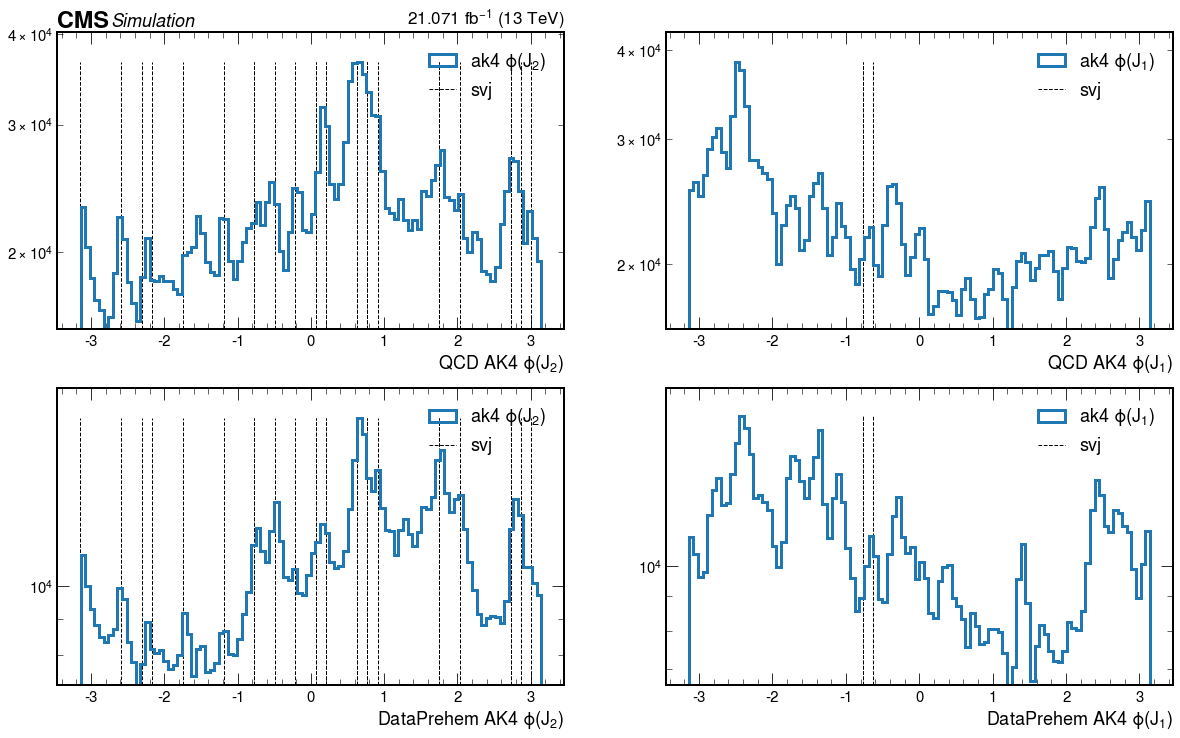

In [97]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
hep.cms.label(data=False, lumi=21.071, ax=ax1, fontsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

phisub = [0.63,-1.19,2.03,3.01,-1.75,-0.77,-2.17,-0.77,2.73,2.73,0.21,0.07,0.21,-2.59,0.07,0.77,0.77,0.91,1.75,1.75,2.87,0.63,-0.49,-2.31,-3.15,-0.21,0.77]
philead = [-0.77,-0.63,-0.77]

qcd_subl_phi_values = ax1.hist(qcd_avr['ak4_subl.phi'], bins=100, histtype='step', linewidth=3, weights=qcd_avr['weight'], label='ak4 $\phi(J_2)$')
y_subl_lim_low  = qcd_subl_phi_values[0].min()
y_subl_lim_high = qcd_subl_phi_values[0].max()
ax1.vlines(x=phisub, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax1.set_yscale('log')
ax1.set_xlabel('QCD AK4 $\phi(J_2)$', fontsize=18)
ax1.legend(fontsize=18)
ax1.set_ylim(y_subl_lim_low, y_subl_lim_high*1.1)

qcd_lead_phi_values = ax2.hist(qcd_avr['ak4_lead.phi'], bins=100, histtype='step', linewidth=3, weights=qcd_avr['weight'], label='ak4 $\phi(J_1)$')
y_lead_lim_low  = qcd_lead_phi_values[0].min()
y_lead_lim_high = qcd_lead_phi_values[0].max()
ax2.vlines(x=philead, ymin = y_lead_lim_low, ymax = y_lead_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax2.set_yscale('log')
ax2.set_xlabel('QCD AK4 $\phi(J_1)$', fontsize=18)
ax2.legend(fontsize=18)
ax2.set_ylim(y_lead_lim_low, y_lead_lim_high*1.1)


data_subl_phi_values = ax3.hist(data_prehem['ak4_subl.phi'], bins=100, histtype='step', linewidth=3, label='ak4 $\phi(J_2)$')
y_subl_lim_low  = data_subl_phi_values[0].min()
y_subl_lim_high = data_subl_phi_values[0].max()
ax3.vlines(x=phisub, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax3.set_yscale('log')
ax3.set_xlabel('DataPrehem AK4 $\phi(J_2)$', fontsize=18)
ax3.legend(fontsize=18)
ax3.set_ylim(y_subl_lim_low, y_subl_lim_high*1.1)

data_lead_phi_values = ax4.hist(data_prehem['ak4_lead.phi'], bins=100, histtype='step', linewidth=3, label='ak4 $\phi(J_1)$')
y_lead_lim_low  = data_lead_phi_values[0].min()
y_lead_lim_high = data_lead_phi_values[0].max()
ax4.vlines(x=philead, ymin = y_lead_lim_low, ymax = y_lead_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax4.set_yscale('log')
ax4.set_xlabel('DataPrehem AK4 $\phi(J_1)$', fontsize=18)
ax4.legend(fontsize=18)
ax4.set_ylim(y_lead_lim_low, y_lead_lim_high*1.1)


fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_data_lead_subl_phi.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_data_lead_subl_phi.pdf')

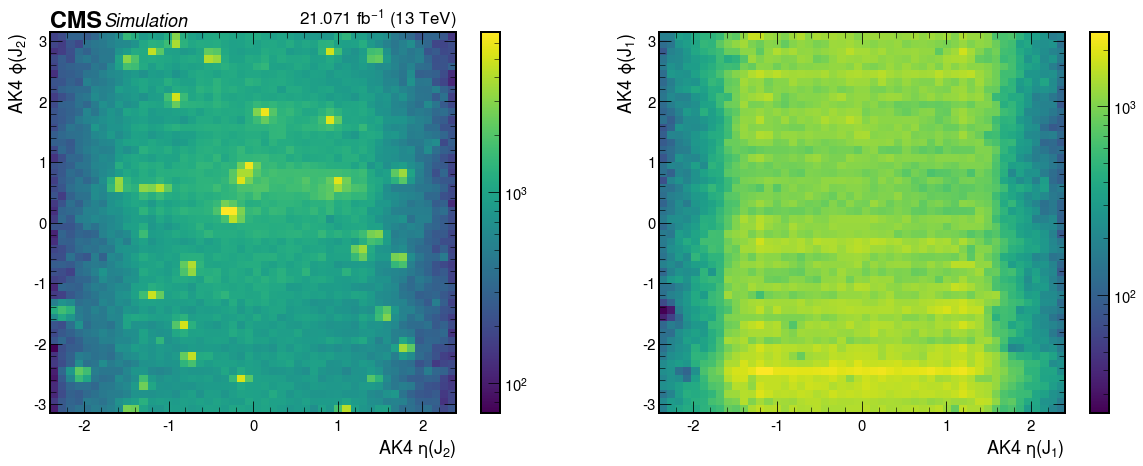

In [98]:
# 2D eta and phi; leading and sub-leading ak4 jets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
hep.cms.label(data=False, lumi=21.071, ax=ax1, fontsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plot = ax1.hist2d(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], weights=qcd_avr['weight'], bins=50, norm=LogNorm())
plt.colorbar(plot[3], ax=ax1)
ax1.set_xlabel('AK4 $\eta(J_2)$', fontsize=18)
ax1.set_ylabel('AK4 $\phi(J_2)$', fontsize=18)

plot = ax2.hist2d(qcd_avr['ak4_lead.eta'], qcd_avr['ak4_lead.phi'], weights=qcd_avr['weight'], bins=50, norm=LogNorm())
plt.colorbar(plot[3], ax=ax2)
ax2.set_xlabel('AK4 $\eta(J_1)$', fontsize=18)
ax2.set_ylabel('AK4 $\phi(J_1)$', fontsize=18)


fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_phi_vs_eta_lead_subl.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_phi_vs_eta_lead_subl.pdf')

In [99]:
# normalized plot to the maximum eta bin:

#normalized_plot(jet_eta, jet_phi, weights, title, var_labels, data)
normalized_plot(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], weights=qcd_avr['weight'], title='QCD', var_labels=['AK4 $\eta(J_2)$', 'AK4 $\phi(J_2)$'], data=False)
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_phi_vs_eta_subl_norm_etabins.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_phi_vs_eta_subl_norm_etabins.pdf')
plt.close()

normalized_plot(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], weights=np.ones_like(data_prehem['ak4_subl.phi'])*1, title='DataPrehem', var_labels=['AK4 $\eta(J_2)$', 'AK4 $\phi(J_2)$'], data=False)
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/data_phi_vs_eta_subl_norm_etabins.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/data_phi_vs_eta_subl_norm_etabins.pdf')
plt.close()

In [ ]:
qcd_eff_5s, qcd_eff_4s, qcd_eff_3s, qcd_etaphi_filter_5s, qcd_etaphi_filter_4s, qcd_etaphi_filter_3s = filter_eff_phi_veto(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], weights=qcd_avr['weight'])
plt.close()

In [ ]:
dataprehem_eff_5s, dataprehem_eff_4s, dataprehem_eff_3s, dataprehem_etaphi_filter_5s, dataprehem_etaphi_filter_4s, dataprehem_etaphi_filter_3s = filter_eff_phi_veto(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], weights=np.ones_like(data_prehem['ak4_subl.phi'])*1)
plt.close()


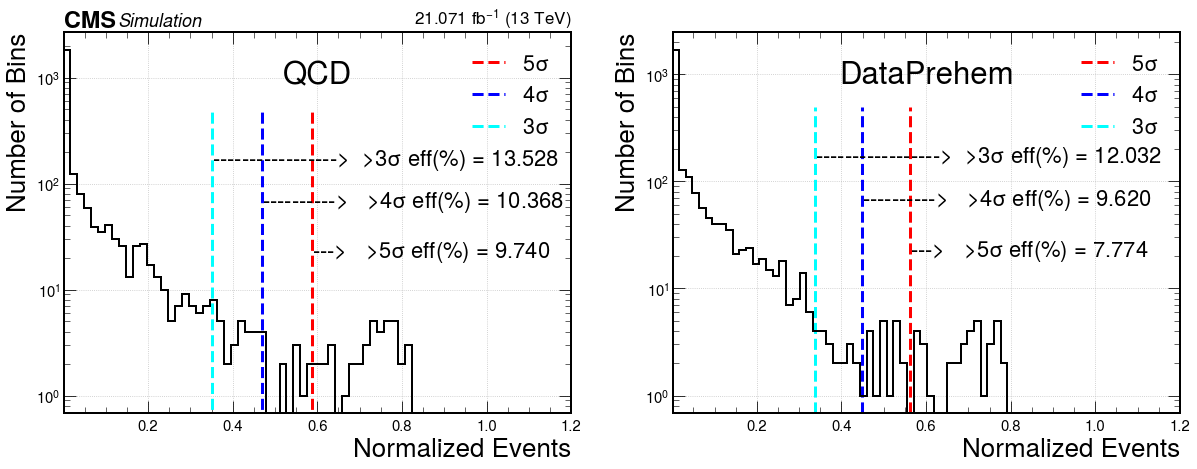

In [96]:
qcd_std, qcd_matrix, qcd_H_norm_list = sigma_matrix_list(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], weights=qcd_avr['weight'])
dataprehem_std, dataprehem_matrix, dataprehem_H_norm_list = sigma_matrix_list(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], weights=np.ones_like(data_prehem['ak4_subl.phi'])*1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
hep.cms.label(data=False, lumi=21.071, ax=ax1, fontsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

ax1.hist(qcd_H_norm_list, bins=50, histtype='step', linewidth=2, color='black')
ax1.vlines(x=qcd_std*5, ymin = 0, ymax = len(qcd_H_norm_list)/5, color='red', linewidth=3, linestyles='dashed', label='5$\sigma$')
ax1.text(qcd_std*5, 20, '--->   >5$\sigma$ eff(%) = {:.3f}'.format(100 - qcd_eff_5s*100), fontsize = 22)
ax1.vlines(x=qcd_std*4, ymin = 0, ymax = len(qcd_H_norm_list)/5, color='blue', linewidth=3, linestyles='dashed', label='4$\sigma$')
ax1.text(qcd_std*4, 60, '---------->   >4$\sigma$ eff(%) = {:.3f}'.format(100 - qcd_eff_4s*100), fontsize = 22)
ax1.vlines(x=qcd_std*3, ymin = 0, ymax = len(qcd_H_norm_list)/5, color='cyan', linewidth=3, linestyles='dashed', label='3$\sigma$')
ax1.text(qcd_std*3, 150, '----------------->  >3$\sigma$ eff(%) = {:.3f}'.format(100 - qcd_eff_3s*100), fontsize = 22)
ax1.grid()
ax1.set_yscale('log')
ax1.set_xlim(0.001,1.2)
ax1.set_xlabel('Normalized Events')
ax1.set_ylabel('Number of Bins')
ax1.set_title('QCD', y=0.85)
ax1.legend()


ax2.hist(dataprehem_H_norm_list, bins=50, histtype='step', linewidth=2, color='black')
ax2.vlines(x=dataprehem_std*5, ymin = 0, ymax = len(dataprehem_H_norm_list)/5, color='red', linewidth=3, linestyles='dashed', label='5$\sigma$')
ax2.text(dataprehem_std*5, 20, '--->   >5$\sigma$ eff(%) = {:.3f}'.format(100 - dataprehem_eff_5s*100), fontsize = 22)
ax2.vlines(x=dataprehem_std*4, ymin = 0, ymax = len(dataprehem_H_norm_list)/5, color='blue', linewidth=3, linestyles='dashed', label='4$\sigma$')
ax2.text(dataprehem_std*4, 60, '---------->   >4$\sigma$ eff(%) = {:.3f}'.format(100 - dataprehem_eff_4s*100), fontsize = 22)
ax2.vlines(x=dataprehem_std*3, ymin = 0, ymax = len(dataprehem_H_norm_list)/5, color='cyan', linewidth=3, linestyles='dashed', label='3$\sigma$')
ax2.text(dataprehem_std*3, 150, '----------------->  >3$\sigma$ eff(%) = {:.3f}'.format(100 - dataprehem_eff_3s*100), fontsize = 22)
ax2.grid()
ax2.set_yscale('log')
ax2.set_xlim(0.001,1.2)
ax2.set_xlabel('Normalized Events')
ax2.set_ylabel('Number of Bins')
ax2.set_title('DataPrehem', y=0.85)
ax2.legend()

fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_data_phi_subl_nbins_vs_normevents_maxcolumn.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_data_phi_subl_nbins_vs_normevents_maxcolumn.pdf')

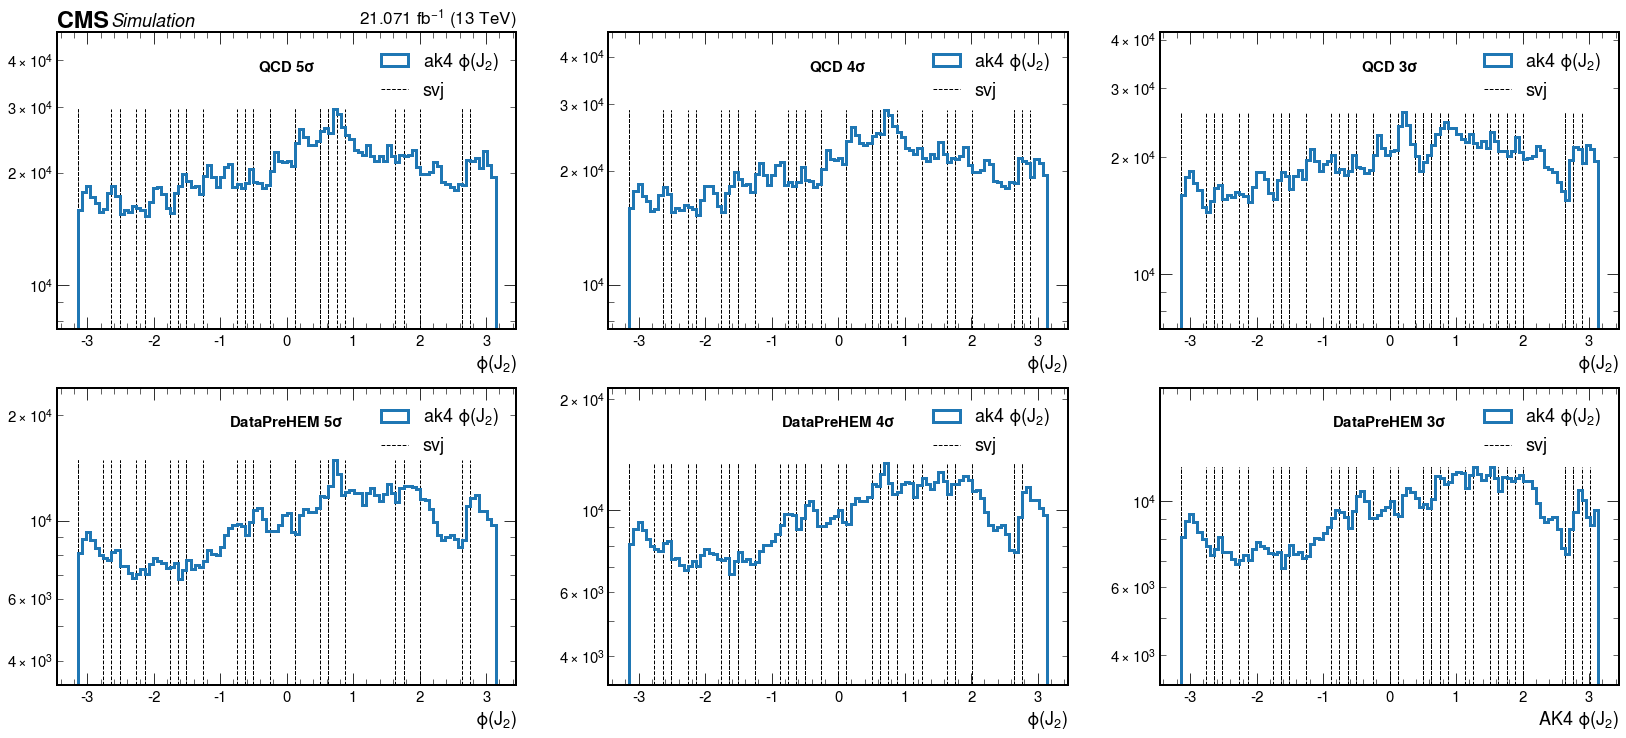

In [95]:
qcd_eta_3s, qcd_phi_3s, qcd_H_3sigma, qcd_eta_4s, qcd_phi_4s, qcd_H_4sigma, qcd_eta_5s, qcd_phi_5s, qcd_H_5sigma = eta_phi_sigma(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], qcd_avr['weight'])
dataprehem_eta_3s, dataprehem_phi_3s, dataprehem_H_3sigma, dataprehem_eta_4s, dataprehem_phi_4s, dataprehem_H_4sigma, dataprehem_eta_5s, dataprehem_phi_5s, dataprehem_H_5sigma = eta_phi_sigma(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], np.ones_like(data_prehem['ak4_subl.phi'])*1)



fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(28, 12))
hep.cms.label(data=False, lumi=21.071, ax=ax1, fontsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

phisub = [0.63,-1.19,2.03,3.01,-1.75,-0.77,-2.17,-0.77,2.73,2.73,0.21,0.07,0.21,-2.59,0.07,0.77,0.77,0.91,1.75,1.75,2.87,0.63,-0.49,-2.31,-3.15,-0.21,0.77]
phisubl = [-0.77,-0.63,-0.77]

qcd_subl_phi_values_5s = ax1.hist(qcd_avr['ak4_subl.phi'][qcd_etaphi_filter_5s], bins=100, histtype='step', linewidth=3, weights=qcd_avr['weight'][qcd_etaphi_filter_5s], label='ak4 $\phi(J_2)$')
y_subl_lim_low  = qcd_subl_phi_values_5s[0].min()/2
y_subl_lim_high = qcd_subl_phi_values_5s[0].max()
ax1.vlines(x=qcd_phi_5s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax1.set_yscale('log')
ax1.set_xlabel('$\phi(J_2)$', fontsize=18)
ax1.set_title('QCD 5$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax1.legend(fontsize=18)
ax1.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)

qcd_subl_phi_values_4s = ax2.hist(qcd_avr['ak4_subl.phi'][qcd_etaphi_filter_4s], bins=100, histtype='step', linewidth=3, weights=qcd_avr['weight'][qcd_etaphi_filter_4s], label='ak4 $\phi(J_2)$')
y_subl_lim_low  = qcd_subl_phi_values_4s[0].min()/2
y_subl_lim_high = qcd_subl_phi_values_4s[0].max()
ax2.vlines(x=qcd_phi_4s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax2.set_yscale('log')
ax2.set_xlabel('$\phi(J_2)$', fontsize=18)
ax2.set_title('QCD 4$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax2.legend(fontsize=18)
ax2.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)


qcd_subl_phi_values_3s = ax3.hist(qcd_avr['ak4_subl.phi'][qcd_etaphi_filter_3s], bins=100, histtype='step', linewidth=3, weights=qcd_avr['weight'][qcd_etaphi_filter_3s], label='ak4 $\phi(J_2)$')
y_subl_lim_low  = qcd_subl_phi_values_3s[0].min()/2
y_subl_lim_high = qcd_subl_phi_values_3s[0].max()
ax3.vlines(x=qcd_phi_3s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax3.set_yscale('log')
ax3.set_xlabel('$\phi(J_2)$', fontsize=18)
ax3.set_title('QCD 3$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax3.legend(fontsize=18)
ax3.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)

dataprehem_subl_phi_values_5s = ax4.hist(data_prehem['ak4_subl.phi'][dataprehem_etaphi_filter_5s], bins=100, histtype='step', linewidth=3, label='ak4 $\phi(J_2)$')
y_subl_lim_low  = dataprehem_subl_phi_values_5s[0].min()/2
y_subl_lim_high = dataprehem_subl_phi_values_5s[0].max()
ax4.vlines(x=dataprehem_phi_5s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax4.set_yscale('log')
ax4.set_xlabel('$\phi(J_2)$', fontsize=18)
ax4.legend(fontsize=18)
ax4.set_title('DataPreHEM 5$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax4.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)

dataprehem_subl_phi_values_4s = ax5.hist(data_prehem['ak4_subl.phi'][dataprehem_etaphi_filter_4s], bins=100, histtype='step', linewidth=3, label='ak4 $\phi(J_2)$')
y_subl_lim_low  = dataprehem_subl_phi_values_4s[0].min()/2
y_subl_lim_high = dataprehem_subl_phi_values_4s[0].max()
ax5.vlines(x=dataprehem_phi_4s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax5.set_yscale('log')
ax5.set_xlabel('$\phi(J_2)$', fontsize=18)
ax5.legend(fontsize=18)
ax5.set_title('DataPreHEM 4$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax5.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)


dataprehem_subl_phi_values_3s = ax6.hist(data_prehem['ak4_subl.phi'][dataprehem_etaphi_filter_3s], bins=100, histtype='step', linewidth=3, label='ak4 $\phi(J_2)$')
y_subl_lim_low  = dataprehem_subl_phi_values_3s[0].min()/2
y_subl_lim_high = dataprehem_subl_phi_values_3s[0].max()
ax6.vlines(x=dataprehem_phi_3s, ymin = y_subl_lim_low, ymax = y_subl_lim_high, color='black', linewidth=1, linestyles='dashed', label='svj')
ax6.set_yscale('log')
ax6.set_xlabel('AK4 $\phi(J_2)$', fontsize=18)
ax6.set_title('DataPreHEM 3$\sigma$', y=0.85, fontsize=15, fontweight="bold")
ax6.legend(fontsize=18)
ax6.set_ylim(y_subl_lim_low, y_subl_lim_high*1.6)

fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_data_subl_phi_345sigma.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_data_subl_phi_345sigma.pdf')




In [94]:
qcd_counts, qcd_xbins, qcd_ybins = jet_counts_xbins_ybins(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], qcd_avr['weight'])
dataprehem_counts, dataprehem_xbins, dataprehem_ybins = jet_counts_xbins_ybins(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], np.ones_like(data_prehem['ak4_subl.phi'])*1)


qcd_eta_3s, qcd_phi_3s, qcd_H_3sigma, qcd_eta_4s, qcd_phi_4s, qcd_H_4sigma, qcd_eta_5s, qcd_phi_5s, qcd_H_5sigma = eta_phi_sigma(qcd_avr['ak4_subl.eta'], qcd_avr['ak4_subl.phi'], qcd_avr['weight'])
dataprehem_eta_3s, dataprehem_phi_3s, dataprehem_H_3sigma, dataprehem_eta_4s, dataprehem_phi_4s, dataprehem_H_4sigma, dataprehem_eta_5s, dataprehem_phi_5s, dataprehem_H_5sigma = eta_phi_sigma(data_prehem['ak4_subl.eta'], data_prehem['ak4_subl.phi'], np.ones_like(data_prehem['ak4_subl.phi'])*1)



fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(28, 28))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
hep.cms.label(data=False, lumi=137.6, ax=ax1, fontsize=20)

var_labels=['AK4 $\phi(J_2)$', 'AK4 $\eta(J_2)$']

H_sigma = [qcd_H_5sigma, dataprehem_H_5sigma, qcd_H_4sigma, dataprehem_H_4sigma, qcd_H_3sigma, dataprehem_H_3sigma]
axs = [ax11, ax12, ax21, ax22, ax31, ax32]

xbins = [qcd_xbins, dataprehem_xbins, qcd_xbins, dataprehem_xbins, qcd_xbins, dataprehem_xbins]
ybins = [qcd_ybins, dataprehem_ybins, qcd_ybins, dataprehem_ybins, qcd_ybins, dataprehem_ybins]

eta = [qcd_eta_5s, dataprehem_eta_5s, qcd_eta_4s, dataprehem_eta_4s, qcd_eta_3s, dataprehem_eta_3s]
phi = [qcd_phi_5s, dataprehem_phi_5s, qcd_phi_4s, dataprehem_phi_4s, qcd_phi_3s, dataprehem_phi_3s]

title = ['QCD <5$\sigma$', 'DataPreHEM <5$\sigma$', 'QCD <4$\sigma$', 'DataPreHEM <4$\sigma$', 'QCD <3$\sigma$', 'DataPreHEM <3$\sigma$']
for i in range(len(axs)):
    plot = axs[i].pcolormesh(xbins[i], ybins[i], H_sigma[i], vmin=0, vmax=0.8)
    axs[i].plot(eta[i], phi[i], 'o', color='white')
    axs[i].set_title(title[i], x=0.8, y=0.85, fontsize=22, color='white', fontweight="bold")
    axs[i].set_xlabel(var_labels[1])
    axs[i].set_ylabel(var_labels[0])
    plt.colorbar(plot, ax=axs[i])


fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/png/qcd_dataprehem_subl_lead_phi_vs_eta_345sigma_svj_deadremoved_maxcolumn.png')
fig.savefig('CR_plots/cr_definitionplots/svj_meeting_01122023/pdf/qcd_dataprehem_subl_lead_phi_vs_eta_345sigma_svj_deadremoved_maxcolumn.pdf')
plt.close()
